# Topic modeling by latent Dirichlet allocation 

## Application to psoriatic arthritis (PsA) and type 1 diabetes (T1D)

We present in this notebook a topic modeling by LDA proof-of-concept. We fit an LDA topic model on a sample containing patients diagnosed with either PsA or type 1 diabetes - which we refer to as 'focal diseases' - along with all their other diagnoses. Our aim is to assess whether we can recover two disease topics with structures reflecting the landscape of comorbidities expected for each focal disease.

Patient disease profiles were obtained from the UK Biobank. We selected all individuals who were diagnosed with PsA, T1D or both (only 3 individuals were diagnosed with both). Our input sample consisted of:
* $I$ = 1885 individuals of which 943 are PsA patients and 945 are T1D patients.
* $J$ = 1100 level-2 ICD-10 codes corresponding to the set of all diagnoses reported within our sample of patients. We will later reduce the number of codes considered.

## 1. Pre-processing

> Load packages

In [82]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA  
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.cluster import hierarchy
import random
import time

> Import data

In [83]:
path = "/gpfs1/well/mcvean/ukbb12788/qsk276/UKB/data/"
datadir = '/gpfs1/well/mcvean/ukbb12788/qsk276/UKB/'

In [103]:
# Import HES data
codes_hes = np.load(path+'codes_dict.npy', allow_pickle=True).item()
icd10_dict = np.load(path+'icd10_diagnosis_41270_dict_2.npy', allow_pickle=True).item()
sample_dict = np.load(path+'icd10_diagnosis_date_41270_41280_dict.npy', allow_pickle=True).item()
sample_age_dict = np.load(path+'icd10_diagnosis_age_41270_41280_dict.npy', allow_pickle=True).item()

# Import self-reported data (not required here)
codes_sr = np.load(path+'codes_sr_dict.npy', allow_pickle=True).item()
sr_dict = np.load(path+'self_reported_20002_dict.npy', allow_pickle=True).item()
sample_sr_age_dict = np.load(path+'self_reported_age_20002_20009_dict.npy', allow_pickle=True).item()

# List of icd10 codes
icd = pd.read_csv(datadir+'data/icd10_2016.csv', sep = '\t')

> Import patient ids and diagnoses

In [119]:
"""Various functions used to import and pre-process input data"""

def get_indivs(df):
#     ind = df.iloc[:,0].values
    ind = df.index.values
    return list(ind)

def get_pheno(df, rr, p):
    pheno = df.index.values
    return list(pheno)

def get_pheno_by_rr(df, rr, p):
    pheno = df.loc[df['p_val']<p,:].index.values
    return list(pheno)

def get_pheno_count(inds, icd_phenos, sr_phenos):
    all_rows = []
    exceptions = []
    for i in inds:
        # For each ind i, get array of presence/absence of (icd+sr phenos)
        row = []
        i_p = list(sample_age_dict[i].keys())
        i_p = [p[:3] for p in i_p] # Reduce phenotype to level 2
        i_p = [p for p in i_p if p in icd_phenos]
        # If have sr phenotypes
        if any(sr_phenos):
            try:
                i_p_sr = list(sample_sr_age_dict[i].keys())
                i_p_sr = [p for p in i_p_sr if p in list(sr_phenos.keys())]
                i_p.extend([sr_phenos[p] for p in i_p_sr])
            except: # some indivs are not in SR dictionary
                exceptions.append(i)

        row = np.array(list(set(i_p))) # to remove any redundant codes
        all_rows.append(row)
    return all_rows

from sklearn.feature_extraction.text import CountVectorizer
# Convert 2d array of inds x phenos to bag-of-word (bag-of-phenos)
def vectorize_data_into_bow(data):
    # Convert rows to string
    for i in range(len(data)):
        data[i] = ' '.join(data[i])
    count_vectorizer = CountVectorizer(analyzer = 'word', lowercase=False)
    bow = count_vectorizer.fit_transform(data) # use .toarray() to convert to array
    return bow, count_vectorizer.get_feature_names()

# Get 'bag-of-words' (absence/presence pheno in each ind) for LDA input
def get_data(inds, icd_phenos, sr_phenos):
    data = get_pheno_count(inds, icd_phenos, sr_phenos)
    bow, features = vectorize_data_into_bow(data)
    return bow, features

In [120]:
# Import list of patient IDs.
id_file_1 = 'cs_5'; id_file_2 = 'csp_2'; pheno_file_1 = 'cs_5_ct_4'; pheno_file_2 = 'csp_2_ctp_2'
ids_1 = get_indivs(pd.read_csv(datadir+id_file_1+'.csv', index_col=0))
ids_2 = get_indivs(pd.read_csv(datadir+id_file_2+'.csv', index_col=0))
ids = list(set(ids_1+ids_2))

# Import list of phenotype ICD-10 codes
icd_phenos_1 = get_pheno(pd.read_csv(datadir+'comorbidity_rr_'+pheno_file_1+'_.csv', index_col=0), rr, p)
icd_phenos_2 = get_pheno(pd.read_csv(datadir+'comorbidity_rr_'+pheno_file_2+'_.csv', index_col=0), rr, p)
icd_phenos = list(set(icd_phenos_1+icd_phenos_2))

# sr_phenos = {} # Self-reported diagnosis to look for and equivalent ICD code (not applicable here)

> Create the individual-phenotype matrix

In [123]:
# Create a 'bag-of-words' representation of data (phenotype presence or absence for each individual)
bow, phenos = get_data(ids, icd_phenos, sr_phenos)

For each individual (row), each phenotype (column) is encoded as either 0 (never diagnosed) or 1 (diagnosed at least once)

In [9]:
pd.DataFrame(bow.toarray(), index = ids, columns = phenos)

,A02,A04,A05,A06,A08,A09,A16,A18,A38,A40,...,Z90,Z91,Z92,Z93,Z94,Z95,Z96,Z97,Z98,Z99
4456449,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3776519,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3162122,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3719181,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3260433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1351701,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4988960,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4382763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1466416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3776560,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> Assess the sparsity of the input matrix

A sparse matrix is a matrix consisting mostly of null values. We quantify here the sparsity of the input matrix by computing the percentage of cells with value 0.

Low sparsity matters for the following reasons:
* From a computational perspective, sparse matrices increase the space and time complexity of the computation. They require more memory and longer execution time of operations.
* From a biological perspective, a sparese matrix of diagnoses indicates the presence of diagnoses that are due to random occurence and are not important contributors to the disease types underlying the dataset. While it is important to maintain a large number of diagnoses in order to capture any minor patterns of phenotypic variability, we also want to minimise the noise in the matrix to only capture the major disease states that stand out in the dataset.

In [10]:
sparsity = ((bow.toarray() == 0).sum()/(bow.toarray().size)*100)
print('With', len(phenos), 'diagnostic codes and', len(ids), 'individuals, the individual-phenotype matrix is', sparsity, '%', 'sparse')

The individual-phenotype matrix is 98.68193875090427 % sparse


To reduce noise and sparsity of our matrix, we filter down the 1100 codes to only keep those significantly associated to either PsA or T1D. We do so by computing the relative risk (RR) for each code and selecting codes with a RR>0 and p-value<0.05.

In [12]:
# We computed the RR of each code relative to PsA and T1D in a separate file. 
#We upload here the results of the computation and select codes meeting the conditions stated above.

rr = 0 # RR threshold for comorbidities
p = 0.05 # p-value threshold for comorbidities

icd_phenos_1 = get_pheno_by_rr(pd.read_csv(datadir+'comorbidity_rr_'+pheno_file_1+'_.csv', index_col=0), rr, p)
icd_phenos_2 = get_pheno_by_rr(pd.read_csv(datadir+'comorbidity_rr_'+pheno_file_2+'_.csv', index_col=0), rr, p)
icd_phenos = list(set(icd_phenos_1+icd_phenos_2))

In [122]:
len(icd_phenos)

70

The resulting set consists of 70 different level-2 ICD-10 codes.

In [12]:
# Recreate a 'bag-of-words' representation of data
bow, phenos = get_data(ids, icd_phenos, sr_phenos)

In [13]:
sparsity = ((bow.toarray() == 0).sum()/(bow.toarray().size)*100)
print('The matrix is now', len(phenos), sparsity, '%', 'sparse')

The matrix is now  94.31906025009474 % sparse


## 1. Model selection with grid search by cross-validation

One the most important aspect of using a learning algorithm is hyperparameter optimisation/model selection. This entails tuning the various hyperparameters of a model to identify the parametrisation that results in a model with highest inference accuracy (accuracy which is estimated based on pre-defined metrics)

The hyperparameters at play for the LDA implementation used are:
* $K$ - the number of topics
* $\alpha_{J}$ - the Dirichlet prior for the topic-phenotype distribution $\pi_{k}$
* $\alpha_{K}$ - the Dirichlet prior for the individual-phenotype distribution $\theta_{i}$
* learning_decay - controls the learning rate of the online version of the variational inference algorithm used to infer the posterior
* max_iter - the maximum number of iterations

**Grid search**

The standard approach for tuning hyperparameters is to compare the performance of different models. Grid search algorithms do so by looping through all the possible combinations of hyperparamters to find the one that gives the most optimal model. How 'optimal' a model is is determined by the resulting value of a defined scoring variable. Here we choose to score a model based on its log-likelihood.

**K-fold cross validation**

When determining the performance of a given model (i.e. estimating the value of its scoring variable), it is common practice to randomly divide the data into a training set (usually consisting of 70% of the data) and a test set (30%). The training set is used to train the model (given pre-specified hyperparamters) and the test set to test its performance (e.g. accuracy of prediction). It is possible however to observer differences in perfomance depending on the composition of the chosen training and test sets. Cross-validation is used to counter this variance problem by evaluating the model on different test sets. It proceeds by dividing the input data into K equal-sized disjoint subsets (or folds), assigns 1 fold for testing and the remaining K-1 folds for training. It then evaluates the predictive performance of the model using thhis train-test configuration. Then, for each following iteration, it permutes the K folds such that a different fold is used for testing each time. This process is repeated for K times, until each of the K folds has been used as a test set. This process thus ensures that each data point is trained and validated against. The overall performance of the model is then reported as the average of the K model performances. This described the standard process of a k-fold cross-validation (non-exhaustive type of cross-validation), which can be varied in different ways.(CITE - Cross-validation
P Refaeilzadeh, L Tang, H Liu - Encyclopedia of database systems, 2009)

> Grid search of optimal LDA model

I perform here a grid search with 5-fold cross validation using the scikit-learn [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) library to identify the hyperparameters that result in an LDA model with highest likelihood. I fit the model with the following hyperparamter values:

* **number of topics** - $K$ = {2, 3} 
Given that my aim is to extract topics corresponding to PsA and T1D, I restrict my search to 2-3 topics.
* **the Dirichlet prior for the topic-phenotype distribution** - **$\alpha_{J}$** = {0.001, 0.01, 0.1, 1, 10}
* **the Dirichlet prior for the individual-phenotype distribution** - $\theta$: $\alpha_{K}$ = {0.001, 0.01, 0.1, 1, 10}
* **the learning decay** = {0.5, 0.7, 0.9}
* **the maximum number of iterations** = {10, 100}

In [14]:
# 5-fold cross validation
cv = 5
# Search parameters
search_params = {'n_components': [2,3], 'topic_word_prior':[1e-3, 1e-2, 1e-1, 1, 10], 'doc_topic_prior':[1e-3, 1e-2, 1e-1, 1, 1e1], 'max_iter':[10,100], 'learning_decay': [0.5, 0.7, 0.9]}

In [16]:
start = time.time()
# Initialise LDA model
lda = LDA()
# Inititialise Grid search class
model = GridSearchCV(lda, param_grid=search_params, cv=cv, verbose=2)
# Do grid search
model.fit(bow)
print(time.time()-start)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.4s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.5s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.3s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.3s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.5s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.01, total=   2.3s
[CV] doc_topic_pri

[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   2.8s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   2.9s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   3.0s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   2.9s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   3.0s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_

[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.001, total=  21.9s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  24.6s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  20.1s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  21.8s
[CV] doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  21.2s
[CV] doc_topic_

[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=1, total=   2.5s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=1, total=   2.7s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   2.5s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   2.5s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   2.7s
[CV] doc_topic_prior=0.001, learning_decay=0.7

[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.01, total=  19.3s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.01, total=  19.4s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.01, total=  19.3s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1, total=  19.5s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1, total=  19.0s
[CV] doc_topic_prior

[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10, total=  21.6s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10, total=  21.3s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10, total=  21.6s
[CV] doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.001, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=10, total=  21.7s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.6s
[CV] doc_topic_prior=0.001, le

[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1, total=   3.1s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1, total=   3.4s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1, total=   3.2s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1, total=   3.0s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.1, total=   2.8s
[CV] doc_topic_prior=0.001, learni

[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=10, total=  20.9s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001, total=  22.5s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001, total=  22.4s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001, total=  25.8s
[CV] doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.001, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.001, total=  26.2s
[CV] doc_t

[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.1, total=   2.4s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.1, total=   2.7s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=1, total=   2.7s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=1, total=   2.5s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=1, total=   3.3s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter

[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.001, total=  19.3s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.001, total=  19.4s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.001, total=  19.2s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.01, total=  19.0s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.01, total=  19.0s
[CV] doc_topic_prior

[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1, total=  25.7s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1, total=  22.4s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1, total=  25.6s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=1, total=  26.3s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=10, total=  25.4s
[CV] doc_topic_prior=0.01, learning_decay=0.5, max

[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01, total=   2.8s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01, total=   3.2s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01, total=   2.8s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01, total=   3.3s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.01, total=   2.9s
[CV] doc_topic_prior=0.01, learnin

[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=1, total=  19.7s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10, total=  20.4s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10, total=  20.9s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10, total=  20.6s
[CV] doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=10, total=  20.5s
[CV] doc_topic_prior=0.01, learning_decay=0.

[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.01, total=   2.4s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.01, total=   2.4s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.1, total=   2.6s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.1, total=   2.5s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.1, total=   2.5s
[CV] doc_topic_prior=0.01, learning_deca

[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10, total=   2.7s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10, total=   2.7s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10, total=   3.2s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.001, total=  19.1s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.001, total=  19.1s
[CV] doc_topic_prior=0.01, learning_

[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1, total=  22.8s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1, total=  25.4s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1, total=  22.7s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1, total=  21.4s
[CV] doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=0.01, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=1, total=  24.7s
[CV] doc_topic_prior=0.01, learning_de

[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.4s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.7s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.1s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.0s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.01, total=   3.4s
[CV] doc_topic_prior=0.1, learning_d

[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1, total=  20.5s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1, total=  19.9s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1, total=  20.6s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1, total=  20.8s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=1, total=  20.2s
[CV] doc_topic_prior=0.1, learning_decay=0.5, max_iter=100, n

[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.7s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01, total=   3.0s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01, total=   2.9s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01, total=   2.6s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.01, total=   2.6s
[CV] doc_topic_prior=0.1, learning_decay=0

[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1, total=   3.7s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10, total=   3.4s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10, total=   2.9s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10, total=   3.0s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=10, total=   2.9s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=10, n_c

[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01, total=  27.6s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01, total=  22.6s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.1, total=  23.9s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.1, total=  24.2s
[CV] doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.1, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.1, total=  27.9s
[CV] doc_topic_prior=0.1, learning_decay

[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=10, total=   2.8s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=10, total=   3.1s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.1s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.0s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.3s
[CV] doc_topic_prior=0.1, learning_decay=0.

[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.1, total=  20.4s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.1, total=  20.2s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.1, total=  20.1s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=1, total=  19.9s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=0.1, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=1, total=  20.1s
[CV] doc_topic_prior=0.1, learning_decay=0.9, max_i

[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.3s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.5s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.3s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.2s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=0.01, total=   3.2s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=1

[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   3.5s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   3.7s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   3.6s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=1, total=   3.7s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=10, total=   3.9s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=10, n_components=3, topic_word_pr

[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  18.6s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  19.2s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  18.9s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.01, total=  18.4s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=1, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=0.1, total=  15.8s
[CV] doc_topic_prior=1, learning_decay=0.5, max_iter=1

[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   3.5s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   3.6s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   3.4s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=10, total=   3.9s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.001, total=   3.7s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=10, n_components=3, 

[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1, total=  19.3s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1, total=  19.1s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1, total=  19.4s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=0.1, total=  19.0s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_components=2, topic_word_prior=1, total=  20.7s
[CV] doc_topic_prior=1, learning_decay=0.7, max_iter=100, n_compo

[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.3s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.7s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.3s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.001, total=   3.2s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=0.01, total=   3.0s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=1

[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1, total=   3.7s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1, total=   3.7s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1, total=   3.5s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=1, total=   3.8s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_prior=10, total=   3.8s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=10, n_components=3, topic_word_pr

[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01, total=  18.4s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01, total=  18.4s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01, total=  18.6s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.01, total=  17.4s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=1, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=0.1, total=  17.7s
[CV] doc_topic_prior=1, learning_decay=0.9, max_iter=1

[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=2, topic_word_prior=10, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=10, n_components=3, topic_word_prior=0.001, total=   2.1s
[CV] doc_topic_prior=10.0, learning_decay=0.5,

[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1, total=  16.3s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1, total=  15.5s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1, total=  15.9s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1, total=  17.8s
[CV] doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1 
[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=2, topic_word_prior=0.1, total=  16.0s
[CV] doc_topic_prior=10.0, learnin

[CV]  doc_topic_prior=10.0, learning_decay=0.5, max_iter=100, n_components=3, topic_word_prior=10, total=  18.3s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=2, topic_word_prior=0.001, total=   2.2s
[CV] doc_topic_prior=10.0, 

[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.1, total=   2.1s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.1 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=0.1, total=   2.1s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1, total=   2.1s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1, total=   2.1s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=10, n_components=3, topic_word_prior=1, total=   2.1s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter

[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.001, total=  17.6s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.001, total=  17.2s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.001 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.001, total=  17.2s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01, total=  16.8s
[CV] doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01 
[CV]  doc_topic_prior=10.0, learning_decay=0.7, max_iter=100, n_components=3, topic_word_prior=0.01, total=  16.9s
[CV] doc_topic_prior

[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=1, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=10, n_components=2, topic_word_prior=10, total=   2.2s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=10,

[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01, total=  17.1s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01, total=  15.9s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01, total=  17.5s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01, total=  15.8s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=2, topic_word_prior=0.01, total=  15.9s
[CV] doc_topic_prior=10.0

[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=1, total=  18.1s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10, total=  18.8s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10, total=  18.8s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10, total=  18.8s
[CV] doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10 
[CV]  doc_topic_prior=10.0, learning_decay=0.9, max_iter=100, n_components=3, topic_word_prior=10, total=  18.8s
[CV] doc_topic_prior=10.0, learning_decay=0.

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 294.3min finished


17660.193719625473


> Hyperparameters and log-likelihood of the most optimal LDA model

In [17]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best model hyperparameters: ", model.best_params_)

# Log Likelihood Score
print("Best model log-likelihood score: ", model.best_score_)


Best model hyperparameters:  {'doc_topic_prior': 0.1, 'learning_decay': 0.5, 'max_iter': 10, 'n_components': 2, 'topic_word_prior': 0.1}
Best model log-likelihood score:  -4868.04956754385


> Compare LDA model performances

Using the optimal values found for maximum iterations (100), $\alpha_{J}$ (0.1), and $\alpha_{K}$ (0.1), I plot below the log-likelihood scores obtained for different number of topics and different learning decays.

In [71]:
n_topics = list(params['n_topics'])
alpha_J = alpha_K = 1e-6
# 1. For alpha_J, alpha_K = 1e-6
## 1.1 Get log likelihoods
select_5 = (df.learning_decay==0.5) & (df.topic_pheno_prior==alpha_J) & (df.ind_topic_prior==alpha_K)
log_lik_5 = df.loc[select_5,'log_likelihood'].values
select_7 = (df.learning_decay==0.7) & (df.topic_pheno_prior==alpha_J) & (df.ind_topic_prior==alpha_K)
log_lik_7 = df.loc[select_7,'log_likelihood'].values
select_9 = (df.learning_decay==0.9) & (df.topic_pheno_prior==alpha_J) & (df.ind_topic_prior==alpha_K)
log_lik_9 = df.loc[select_9,'log_likelihood'].values
## 1.2 Plot
plt.figure(figsize=(12,8))
plt.plot(n_topics, log_lik_5, label='0.5')
plt.plot(n_topics, log_lik_7, label='0.7')
plt.plot(n_topics, log_lik_9, label='0.9')
plt.title("Optimising LDA model based on number of topics and learning decay")
plt.xlabel("Number of topics (K)")
plt.ylabel("- Log likelihood")
plt.legend(title="Learning decay", loc='best')
plt.show()

NameError: name 'params' is not defined

As indicated by the best model, the log-likelihood is lowest for 2 topics and a learning decay of 0.9

> Explore the effect of the dirichlet priors $\alpha_{J}$, and $\alpha_{K}$ on the topic-phenotype and individual-topic distributions

To concretely understand the role played by the Dirichlet priors in shaping these distributions, I fit multiple LDA models with the optimal hyperparamters found above and vary the value of the Dirichlet priors

In [14]:
"""Various functions used to plot the distributions"""

def plot_prior_heatmap(v, title):
    ax = sns.heatmap(v, vmin=0, vmax=1)
    ax.set_title(title)
    plt.show()
    
def plot_prior_clustermap(v, title):
    ax = sns.clustermap(v, vmin=0, vmax=1, figsize=(5, 5))
    ax.ax_row_dendrogram.set_visible(False)
    ax.ax_col_dendrogram.set_visible(False)
#     ax.set_title(title)
    plt.show()
    
def sort_array(arr,index, reverse):
    return sorted(arr, key=lambda x: x[index], reverse=reverse)

**Topic-phenotype distribution when varying $\alpha_{J}$**

In [124]:
K = 2
learning_decay = 0.9
max_iter = 100
alpha_K = 0.1
alpha_J = list(search_params['alpha_J'])

KeyError: 'alpha_J'

In [ ]:
## Heatmaps

As $\alpha_{J}$ increases, the sparsity of the matrix p decreases. For a small $\alpha_{J}$, for a given topic, most phenotypes have a likelihood of 0 of falling in the topic. Thus each topic becomes characterised with a small and specific set of phenotypes.

**Individual-topic distribution when varying $\alpha_{K}$**

In [76]:
K = 2
learning_decay = 0.9
max_iter = 100
alpha_K = list(search_params['alpha_K'])
alpha_J = 0.1

In [ ]:
## Heatmaps

Similarly, as $\alpha_{K}$ decreases the matrix $\theta$ becomes more dense. Each individual becomes characterised by a small set of topics

## 3. Results

In [139]:
"""Various functions to fit LDA model and display results"""

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA 

# Phenotypes to print
number_phenos = 10

# Print topics
def print_topics(p, phenos, number_words):
    print("Topics found via LDA:")
    
    for index, p_k in enumerate(p):
        print("\nTopic #%d:" % index)
        for i in p_k.argsort()[:-number_words - 1:-1]:
            print(" ".join((phenos[i],icd.loc[icd.code==phenos[i],'desc'].item())))
            
# Print topics
def print_topics_threshold(p, phenos, threshold):
    print("Topics found via LDA:")
    
    for index, p_k in enumerate(p):
        print("\nTopic #%d:" % (index+1))
        for i in p_k.argsort()[::-1]:
            if p_k[i]>threshold:
                try:
                    print(" ".join((phenos[i],icd.loc[icd.code==phenos[i],'desc'].item())))
                except:
                    print(" ".join((phenos[i],phenos[i])))

# Create and fit LDA model
def fit_lda(bow, n_topics, max_iter, topic_pheno_prior, ind_topic_prior, learning_decay):
    start = time.time()
    lda = LDA(n_components=n_topics, max_iter=max_iter, doc_topic_prior=ind_topic_prior, topic_word_prior=topic_pheno_prior, learning_decay=learning_decay, verbose=1)
    lda.fit(bow)
    return lda

# Get parameters and results of LDA model
def get_model_results(model, bow):
    params = model.get_params() 
    model.components_ /= model.components_.sum(axis=1)[:, np.newaxis] #normalise p_k vectors such that sum of all p_k,j = 1
    results = {'n_topics': params['n_components'],
               'max_iter': params['max_iter'],
               'topic_pheno_prior': params['topic_word_prior'],
               'ind_topic_prior': params['doc_topic_prior'],
               'learning_decay': params['learning_decay'],
               'log_likelihood': model.score(bow),
               'perplexity': model.perplexity(bow),
               'p': model.components_,
               'theta': model.transform(bow)
        }
    return results

def run_lda(params, bow):
#     start=time.time()
    # Fit LDA model
    lda = fit_lda(bow, params[0], int(params[1]), params[2], params[3], params[4])
    # Get model results
    results = get_model_results(lda, bow)
#     print('Time:', time.time()-start,'sec')
    return results

>Fit model

We now fit an LDA model on the PsA+T1D dataset using the selected hyperparamaters

In [143]:
# Hyperparameters selected by grid-search
params = [2,10,0.1,0.1,0.5]
# Fit LDA
results = run_lda(params, bow)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [144]:
# Get output
K = params[0]
theta = results['theta']
pi = results['p']

> Explore the structure of the **topic-phenotype distribution**

I print below the top-scoring diagnostic codes in each topic. I only select the topics with a probability of falling in the topic of $\pi_{k,j}> t$

For $\pi_{k,j}> 0.1$

In [145]:
print_topics_threshold(pi, phenos, 0.1)

Topics found via LDA:

Topic #1:
E10 Type 1 diabetes mellitus
I10 Essential (primary) hypertension

Topic #2:
L40 Psoriasis
M07 Psoriatic and enteropathic arthropathies


These correspond to the diagnostic codes with membership probability $\pi_{k,j}>0.1$. We can already see the topics structuring around the diseases we expected. They are each characterised by one focal disease and a major comorbidity of that disease.

For $\pi_{k,j}> 0.04$

In [146]:
print_topics_threshold(pi, phenos, 0.04)

Topics found via LDA:

Topic #1:
E10 Type 1 diabetes mellitus
I10 Essential (primary) hypertension
E16 Other disorders of pancreatic internal secretion
H36 Retinal disorders in diseases classified elsewhere
E03 Other hypothyroidism

Topic #2:
L40 Psoriasis
M07 Psoriatic and enteropathic arthropathies
I10 Essential (primary) hypertension
M06 Other rheumatoid arthritis
M19 Other arthrosis


As we lower the membership probability of codes to a topic, we get comorbidities that are exclusively linked to each focal disease but are less prevalent within the population (e.g. about 70% of PsA patients have RA, while 100% of PsA patients have Psoriasis). We see hypertension in both topics as it is a condition highly prevalent in populations of thsi age-trange in the UKB (regardless of focal phenotype)

For $\pi_{k,j}> 0.02$

In [147]:
print_topics_threshold(pi, phenos, 0.02)

Topics found via LDA:

Topic #1:
E10 Type 1 diabetes mellitus
I10 Essential (primary) hypertension
E16 Other disorders of pancreatic internal secretion
H36 Retinal disorders in diseases classified elsewhere
E03 Other hypothyroidism
G56 Mononeuropathies of upper limb
Z88 Personal history of allergy to drugs, medicaments and biological substances
Z96 Presence of other functional implants

Topic #2:
L40 Psoriasis
M07 Psoriatic and enteropathic arthropathies
I10 Essential (primary) hypertension
M06 Other rheumatoid arthritis
M19 Other arthrosis
M13 Other arthritis
Z88 Personal history of allergy to drugs, medicaments and biological substances
Z96 Presence of other functional implants
M17 Gonarthrosis [arthrosis of knee]
M25 Other joint disorders, not elsewhere classified
M54 Dorsalgia
M79 Other soft tissue disorders, not elsewhere classified
E66 Obesity


Obesity (E66) is known as one of the metabolic markers (potentially risk factors) of PsA

It is important to set a reasonably conservative lower bound for $\pi_{k,j}$. As seen above, lowering the threshold of probabilistic membership to 0.1 reveals codes that are not directly associated to our focal phenotypes.

Below is a heatmap representation of the 2 topic-phenotype distributions (rows). Each cell corresponds to the probability of membership of a code (column) to a topic(row).

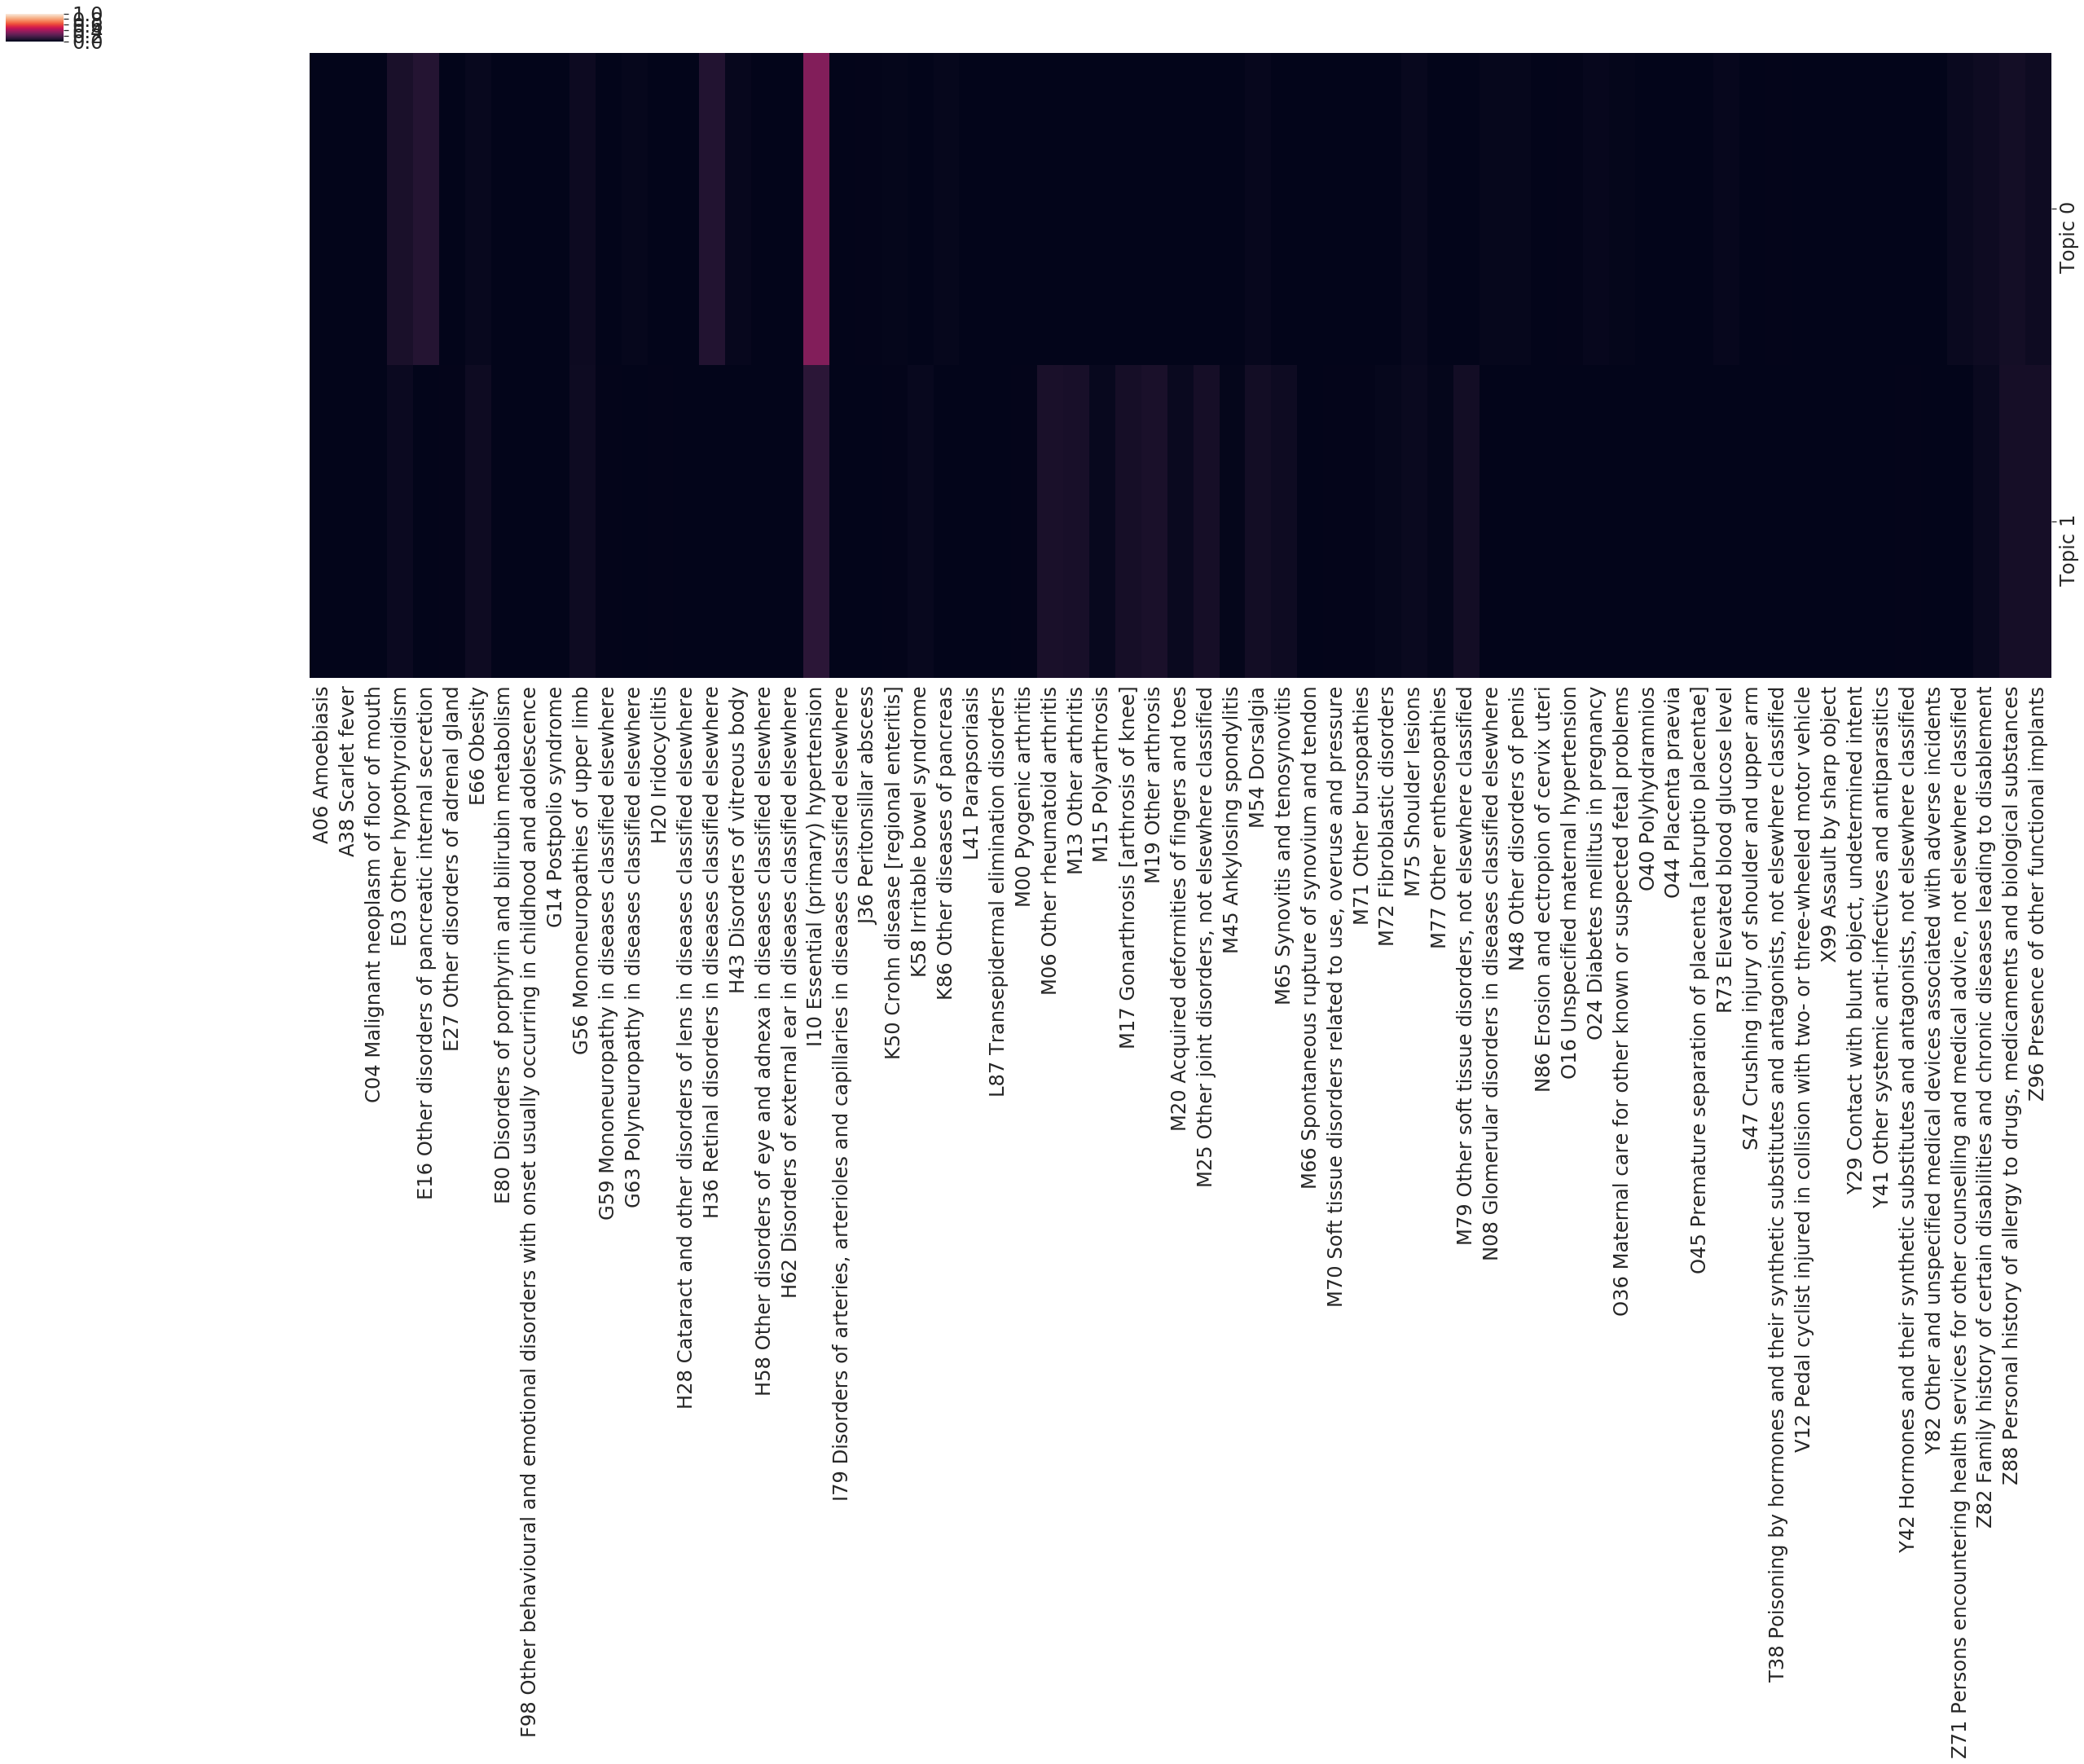

In [162]:
sns.set(font_scale=2.2)
columns = []
for i in range(len(pi[0])):
    try:
        columns.append(" ".join((phenos[i],icd.loc[icd.code==phenos[i],'desc'].item())))
    except:
        columns.append(" ".join((phenos[i],phenos[i])))
df_pi = pd.DataFrame(pi, columns=columns, index=['Topic 0', 'Topic 1'])

row_linkage = scipy.cluster.hierarchy.linkage(df_pi, method="average")
cg = sns.clustermap(df_pi, row_linkage=row_linkage, metric='seuclidean', col_cluster=False, row_cluster=False, figsize=(45, 15), vmin=0, vmax=1)


The matrix is relatively sparse with only a few codes characteristic of each topic.

> Explore the structure of the **individual-topic distribution**

Below is a heatmap representation of the individividual-topic distribution. Individuals are represented in rows and topics in columns. Rows are clustered by hierarchical clustering (euclidean distance metric)

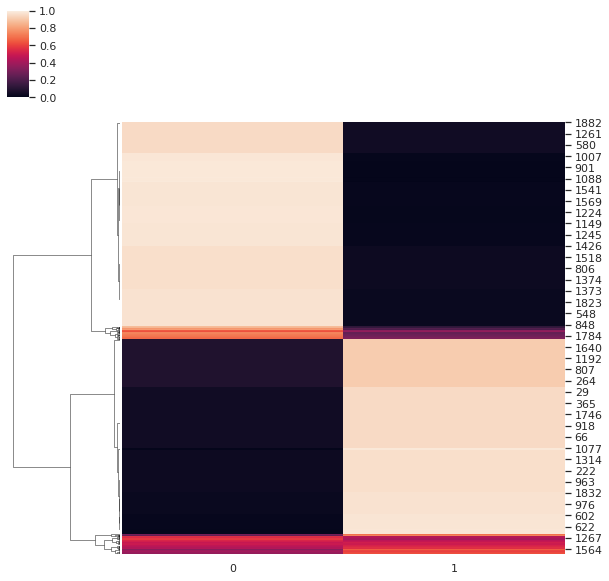

In [78]:
sns.set(font_scale=1)
ax = sns.clustermap(theta, metric='euclidean', col_cluster=False, vmin=0, vmax=1)
plt.show()

This matrix is equally sparse: The majority of individuals exhibit one topic in much larger proprtion than the other. There is on the other hand two ckusters of individuals with a more ambiguous topic representaion: one group (middle rows) which has topic 1 as its dominant topic but in lower likelihood than the preceding rows. Another group of individuals (last rows) show no dominant topic as they exhibit both topics with equal probability. This latter group is likely to correspond to individuals who were not diagnosed by most of the phenotypes we pre-selected in the pre-processing stage.

In [89]:
# column names
topicnames = ["Topic" + str(i) for i in range(K)]

df_ind_topic = pd.DataFrame(np.round(theta, 2), columns = topicnames)

# Get dominant topic for each document
dominant_topic = []
for i in df_ind_topic.index:
    if np.abs(df_ind_topic.iloc[i,0]-df_ind_topic.iloc[i,1])<=0.1:
        dominant_topic.append('none')
    else:
        dominant_topic.append(np.argmax(df_ind_topic.iloc[i,:].values))
df_ind_topic['dominant_topic'] = dominant_topic

df_topic_distribution = df_ind_topic['dominant_topic'].value_counts().reset_index(name="Num individuals")
df_topic_distribution.columns = ['Topic Num', 'Num individuals']
df_topic_distribution

,Topic Num,Num individuals
0,0,965
1,1,892
2,none,28


There are in fact:
* 28 individuals who show no dominant topic, that is, their probability of exhibiting either topics is approximately 0.5 (in the range (0.4, 0.6));
* 965 individuals who exhbit topic 0 (PsA topic) as their dominant topic;
* 892 individuals who exhbit topic 1 (T1D topic) as their dominant topic;

We can also look at the sensitivity of mapping of individuals to topics. We want to know what is the proportion of individuals with either PsA or T1D who exihbit the topic corresponding to their disease type in higher proportion (i.e PsA patients for whom topic 0 is the dominant topic; and T1D patients for whom topic 1 is the dominant topic).

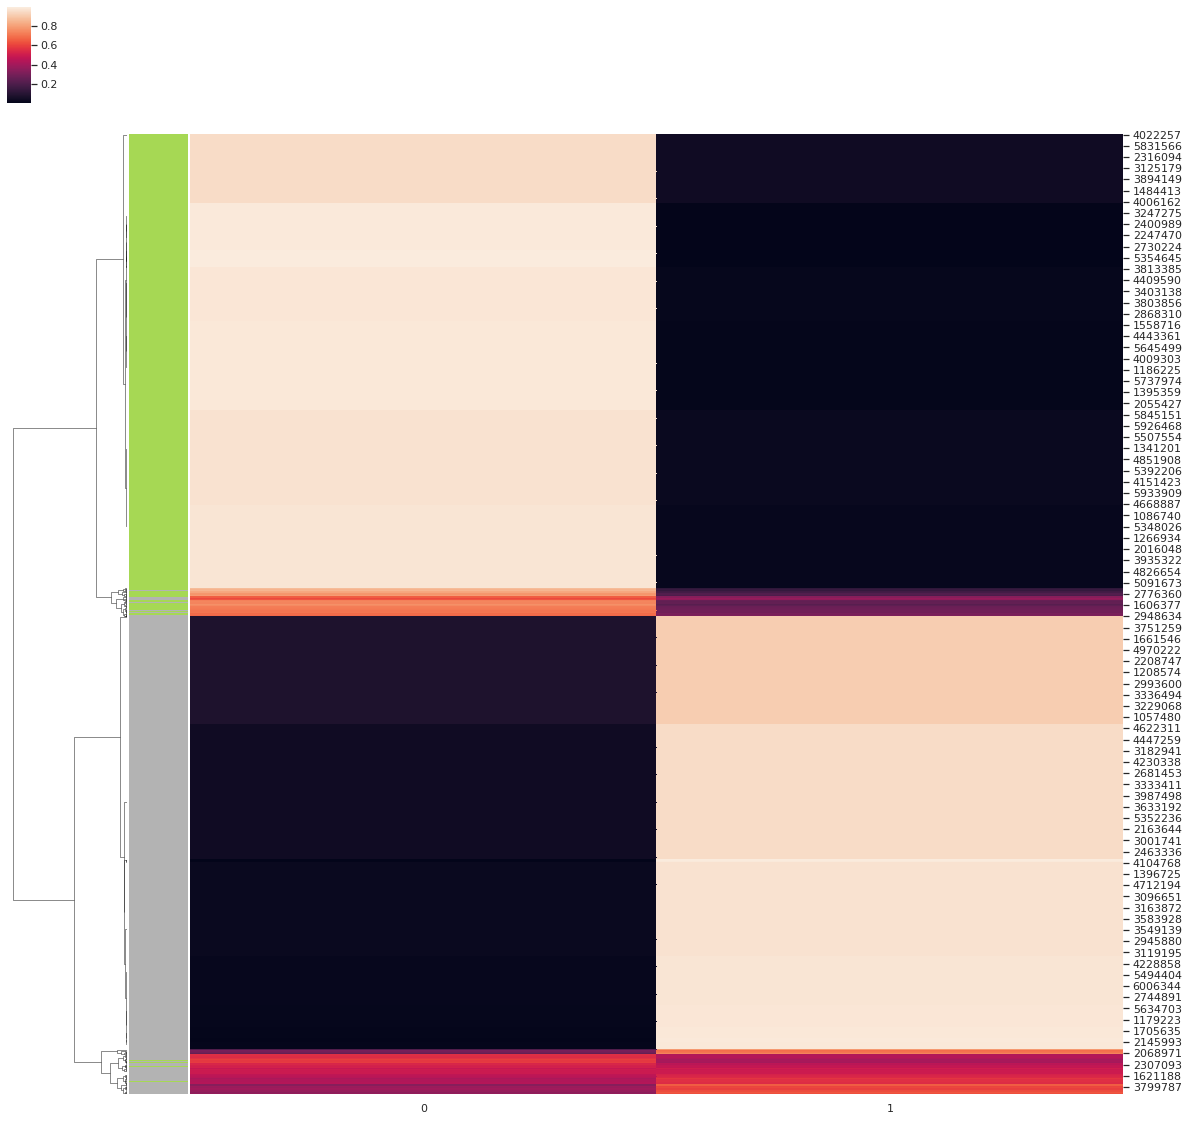

In [90]:
index = [ids[i] for i in range(len(theta))]
df_theta = pd.DataFrame(theta, index=index)

# Assign group to each ind
group = []
for index in df_theta.index:
    if index in ids_1:
        group.append(1)
    else:
        group.append(2)
# Create colourmap
cmap = plt.cm.get_cmap('Set2', K+1)
colourmap = dict(zip(df_theta.index, cmap(group)))

# Order rows
row_linkage = scipy.cluster.hierarchy.linkage(df_theta, method="average")
order = scipy.cluster.hierarchy.leaves_list(row_linkage)
x_pop = df_theta.index.values[order]

# Plot clustermap
row_colors = pd.Series(df_theta.reindex(x_pop).index, index=df_theta.reindex(x_pop).index).map(colourmap)
cg = sns.clustermap(df_theta, row_linkage=row_linkage, metric='euclidean', col_cluster=False, row_colors=row_colors, figsize=(20, 20))

In the heatmap above, the left colorbar identifies the patient type: green rows correspond to patients diagnosed with PsA and grey rows to individuals diagnosed with T1D. We can see that the majority of patients map in high proportion (close to 1) to the topic corresponding to their disease type.

We can quantify the sensitivity of patient's inferred dominant topic:

In [108]:
psa_sens = len([i for i in ids_1 if df_ind_topic.loc[ids.index(i),'dominant_topic']==0 ])/len(ids_1)*100
print('PsA patients show', psa_sens, '% sensitivity in dominant topic assignment')

PsA patients show 99.36373276776246 % sensitivity in dominant topic assignment


In [110]:
t1d_sens = len([i for i in ids_2 if df_ind_topic.loc[ids.index(i),'dominant_topic']==1 ])/len(ids_2)*100
print('T1D patients show', t1d_sens, '% sensitivity in dominant topic assignment')

T1D patients show 94.17989417989418 % sensitivity in dominant topic assignment


These estimates are very high, showing a near perfect classification of patients into topics. However this should have been expected given that the model is aware of the presence or absence of 2 focal diseases

It will be interesting to see if the model can infer accurate disease topics and patient classification when it is only aware of the comorbidities of the focal diseases without knowledge of PsA or T1D diagnoses.

## 4. LDA on comorbidities, without focal diseases

>Pre-processing

We start by removing mention of PsA (M07) and T1D (E10) diagnoses from our dataset. We also remove Ps (L40) given that it is present in all PsA patients.

In [148]:
icd_phenos.remove('E10')
icd_phenos.remove('M07')
icd_phenos.remove('L40')

> Build individual-phenotype matrix

In [149]:
bow, phenos = get_data(ids, icd_phenos, sr_phenos)

> Fit LDA model

In [157]:
# Hyperparameters selected by grid-search
params = [2,10,0.1,0.1,0.5]
# Fit LDA
results = run_lda(params, bow)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [158]:
# Get output
K = params[0]
theta = results['theta']
pi = results['p']

> Explore the structure of the **topic-phenotype distribution**

For $\pi_{k,j}> 0.1$

In [160]:
print_topics_threshold(pi, phenos, 0.1)

Topics found via LDA:

Topic #1:
I10 Essential (primary) hypertension

Topic #2:
I10 Essential (primary) hypertension


For $\pi_{k,j}> 0.04$

In [161]:
print_topics_threshold(pi, phenos, 0.04)

Topics found via LDA:

Topic #1:
I10 Essential (primary) hypertension
E16 Other disorders of pancreatic internal secretion
H36 Retinal disorders in diseases classified elsewhere
E03 Other hypothyroidism
Z88 Personal history of allergy to drugs, medicaments and biological substances

Topic #2:
I10 Essential (primary) hypertension
M06 Other rheumatoid arthritis
M19 Other arthrosis
M13 Other arthritis
Z96 Presence of other functional implants
M25 Other joint disorders, not elsewhere classified
M17 Gonarthrosis [arthrosis of knee]
Z88 Personal history of allergy to drugs, medicaments and biological substances
M79 Other soft tissue disorders, not elsewhere classified
M54 Dorsalgia


For $\pi_{k,j}> 0.02$

In [159]:
print_topics_threshold(pi, phenos, 0.02)

Topics found via LDA:

Topic #1:
I10 Essential (primary) hypertension
E16 Other disorders of pancreatic internal secretion
H36 Retinal disorders in diseases classified elsewhere
E03 Other hypothyroidism
Z88 Personal history of allergy to drugs, medicaments and biological substances
Z96 Presence of other functional implants
Z82 Family history of certain disabilities and chronic diseases leading to disablement
G56 Mononeuropathies of upper limb
Z71 Persons encountering health services for other counselling and medical advice, not elsewhere classified
M75 Shoulder lesions
E66 Obesity

Topic #2:
I10 Essential (primary) hypertension
M06 Other rheumatoid arthritis
M19 Other arthrosis
M13 Other arthritis
Z96 Presence of other functional implants
M25 Other joint disorders, not elsewhere classified
M17 Gonarthrosis [arthrosis of knee]
Z88 Personal history of allergy to drugs, medicaments and biological substances
M79 Other soft tissue disorders, not elsewhere classified
M54 Dorsalgia
E66 Obesit

Despite not having PsA and T1D as indicators of disease subgroups, we can still recover topics representative of these diseases. Topic 0 shows systemic disorders relating to T1D T1D (hypertension, retinal disorders, pancreatic disorders) and Topic 1 shows a majority of diseases relating to the MSK system.

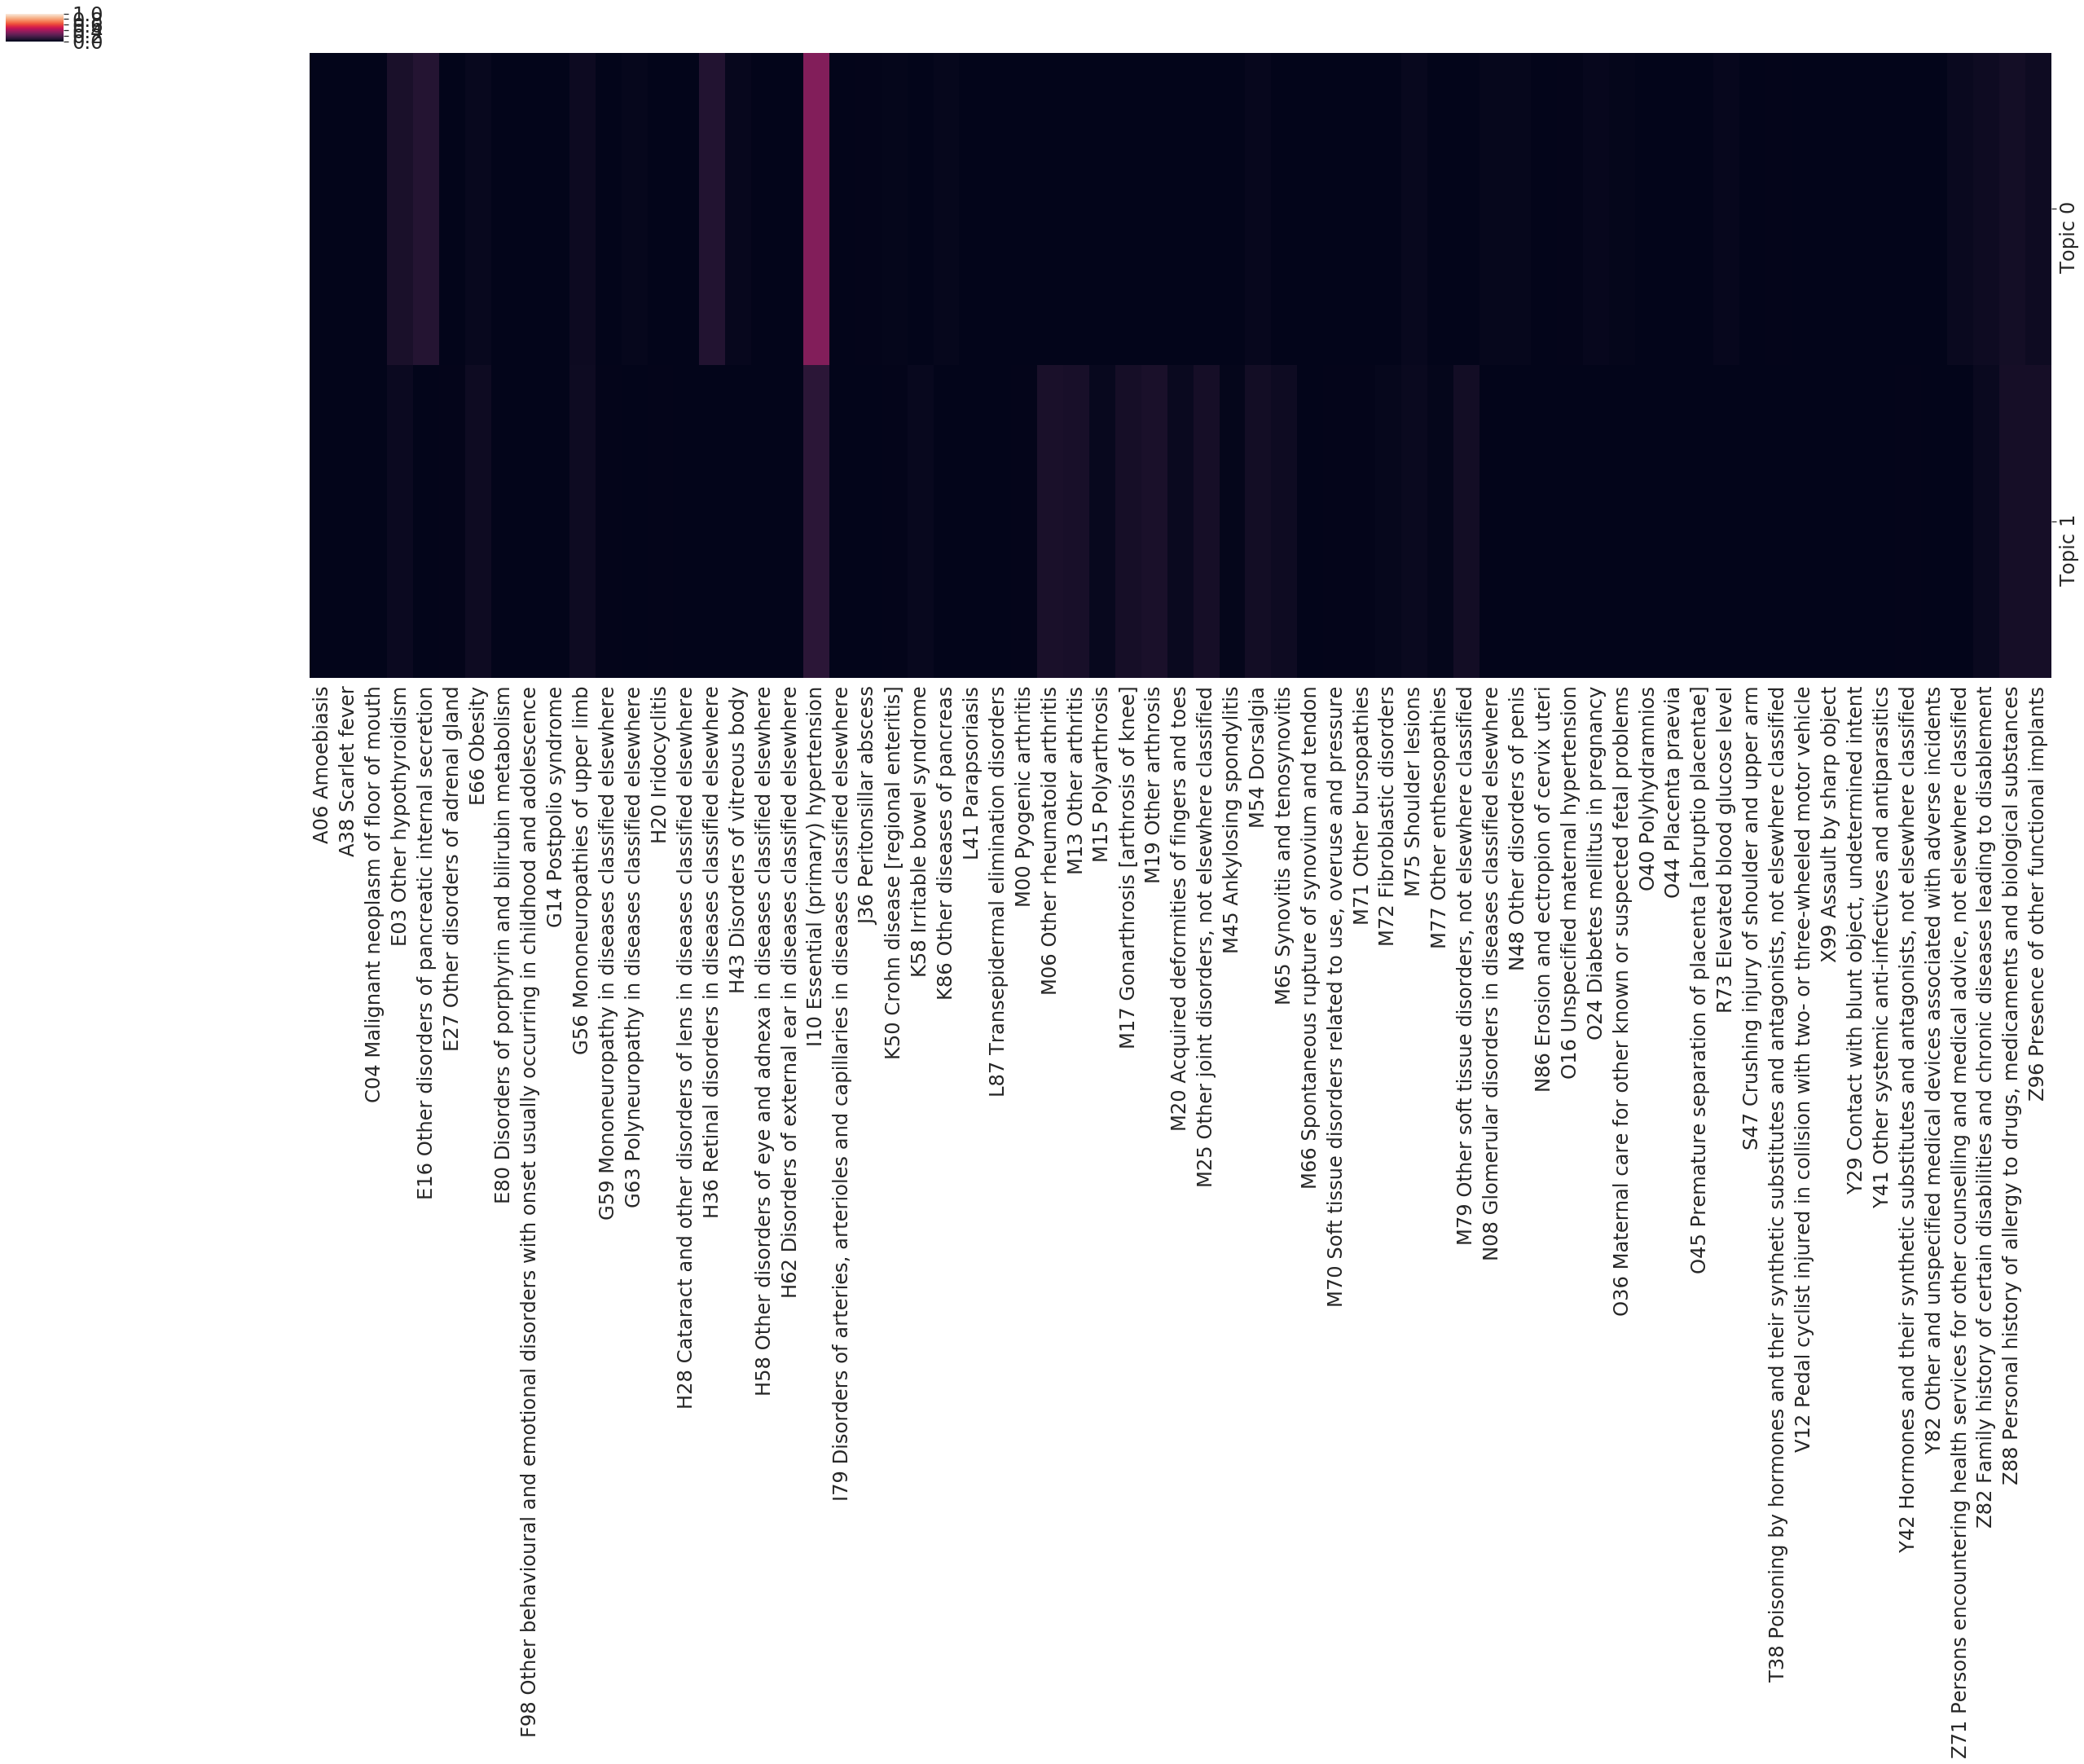

In [163]:
sns.set(font_scale=2.2)
columns = []
for i in range(len(pi[0])):
    try:
        columns.append(" ".join((phenos[i],icd.loc[icd.code==phenos[i],'desc'].item())))
    except:
        columns.append(" ".join((phenos[i],phenos[i])))
df_pi = pd.DataFrame(pi, columns=columns, index=['Topic 0', 'Topic 1'])

row_linkage = scipy.cluster.hierarchy.linkage(df_pi, method="average")
cg = sns.clustermap(df_pi, row_linkage=row_linkage, metric='seuclidean', col_cluster=False, row_cluster=False, figsize=(45, 15), vmin=0, vmax=1)


Additionally, the distribution of topics remains relatively sparse with a handful of codes defining each topic.

> Explore the structure of the **individual-topic distribution**

Let's look now at the sensitivity of dominant topic prediction obtained when removing focal phenotypes

In [164]:
# column names
topicnames = ["Topic" + str(i) for i in range(K)]

df_ind_topic = pd.DataFrame(np.round(theta, 2), columns = topicnames)

# Get dominant topic for each document
dominant_topic = []
for i in df_ind_topic.index:
    if np.abs(df_ind_topic.iloc[i,0]-df_ind_topic.iloc[i,1])<=0.1:
        dominant_topic.append('none')
    else:
        dominant_topic.append(np.argmax(df_ind_topic.iloc[i,:].values))
df_ind_topic['dominant_topic'] = dominant_topic

df_topic_distribution = df_ind_topic['dominant_topic'].value_counts().reset_index(name="Num individuals")
df_topic_distribution.columns = ['Topic Num', 'Num individuals']
df_topic_distribution

,Topic Num,Num individuals
0,1,891
1,0,608
2,none,386


A larger number of individuals (386 here as opposed to 28 in the previous model) exhibit both topics with approximately equal proportion

The heatmap below shows the  distribution of topics across individuals:

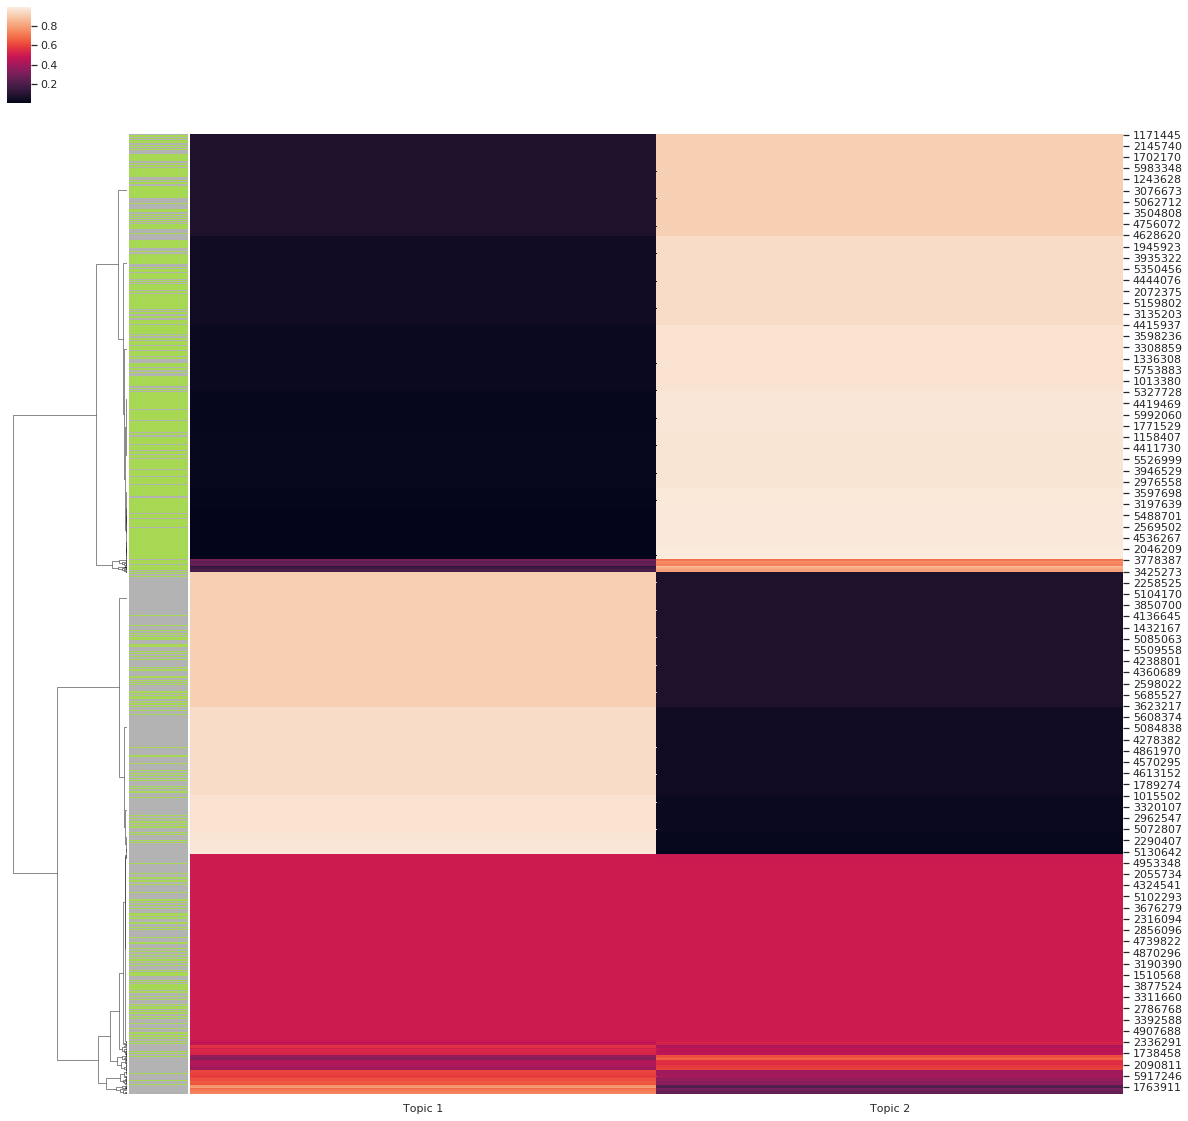

In [176]:
sns.set(font_scale=1)

index = [ids[i] for i in range(len(theta))]
df_theta = pd.DataFrame(theta, index=index, columns = ['Topic 1', 'Topic 2'])

# Assign group to each ind
group = []
for index in df_theta.index:
    if index in ids_1:
        group.append(1)
    else:
        group.append(2)
# Create colourmap
cmap = plt.cm.get_cmap('Set2', K+1)
colourmap = dict(zip(df_theta.index, cmap(group)))

# Order rows
row_linkage = scipy.cluster.hierarchy.linkage(df_theta, method="average")
order = scipy.cluster.hierarchy.leaves_list(row_linkage)
x_pop = df_theta.index.values[order]

# Plot clustermap
row_colors = pd.Series(df_theta.reindex(x_pop).index, index=df_theta.reindex(x_pop).index).map(colourmap)
cg = sns.clustermap(df_theta, row_linkage=row_linkage, metric='euclidean', col_cluster=False, row_colors=row_colors, figsize=(20, 20))

The individuals with no dominant topic (bottom third of the heatmap) consist of a mixture of individuals who have PsA or T1D but do not show usual patterns of comorbidity  

In [177]:
psa_sens = len([i for i in ids_1 if df_ind_topic.loc[ids.index(i),'dominant_topic']==1])/len(ids_1)*100
print('PsA patients show', psa_sens, '% sensitivity in dominant topic assignment')

PsA patients show 68.50477200424177 % sensitivity in dominant topic assignment


In [178]:
t1d_sens = len([i for i in ids_2 if df_ind_topic.loc[ids.index(i),'dominant_topic']==0])/len(ids_2)*100
print('T1D patients show', t1d_sens, '% sensitivity in dominant topic assignment')

T1D patients show 48.46560846560847 % sensitivity in dominant topic assignment


Sensitivity of the model has greatly reduced as a result of removing mention of focal phenotypes but still falls above 50%

This application has shown that LDA has the potential to discriminate between diseases with different patterns of comorbidity. Here it was able to generate topics consisting where components with high proabilistic membership coincided with diseases related to T1D in one topic and PsA in another. The reuslting topics were ths accurate enough representations of the underlying disease states. The distribution of topics over individuals was less specific. Nonetheless, more than 50% of individuals exhibit the topic specific to their disease in higher proprtion. It might be useful to inform the assignment of a topic to an individual by priors on the genotype of the individual which might make them more liable to fall in one topic than another.  